# Objectif 

Réaliser un projet de data science de bout en bout à partir de données de cas d’usage réel. L’objectif sera alors d’appliquer un algorithme d’apprentissage automatique et/ou de réseau neuronal sur un ensemble de données réelles.

Data :
Vous avez 2 sujets donc 2 jeux de données à votre disposition. Vous devez choisir un ensemble de données parmi les 2.


## 1. `Supervision de lignes de bus`

Les transports publics font face tous les jours à des flux de passagers différents. Dans le cadre de sa mission d’amélioration des services proposés à ses usagers, une société souhaite être en mesure (à terme) de :
- Anticiper les fortes affluences d’usagers sur l’ensemble de son réseau en ayant une vision claire des demandes pour chaque ligne et pour chaque arrêt.
- Optimiser les temps de trajets de sa flotte

L’objet de ce challenge est donc de prédire l’affluence des passagers sur des lignes de bus, par jour, pour les 3 prochains jours.

    - Vous aurez à disposition un historique du cumul journalier de voyageurs allant du 05 avril 2019 au 19 mars 2023, pour toutes les lignes de bus de la compagnie. 
    - Le jeu de données est composé de 37 621 observations et 3 variables explicatives originales qui sont, la date, la ligne de bus et le type de ligne de bus (jour ou nuit). 
    - La variable quantitative à prédire est le nombre de passagers/usagers.  

    Variable de sortie : 
    - Nombre de passagers (variable numérique continue) 

## 2. `Détection de fuite`

Pour un opérateur public de distribution d’eau, la détection rapide des fuites sur le réseau est un enjeu stratégique majeur. 
Les équipes terrain interviennent quotidiennement sur des milliers de kilomètres de canalisation, où les fuites peuvent passer inaperçues et entraîner des pertes  importantes d’eau, des coûts élevés et des  perturbations du service.

HUPI travaille depuis plusieurs mois afin de développer un Assistant Virtuel de détection de fuites, basé sur des modèles de Machine Learning. 
Cet assistant prend en compte :
- les caractéristiques du réseau, 
- les données historiques de consommation et de pression, 
- ainsi que le profil et les habitudes de fonctionnement du réseau, afin d’alerter automatiquement et judicieusement lorsqu’un risque de fuite est détecté.

L’objectif est de concevoir des modèles auto-apprenants, capables de s’adapter aux spécificités de chaque zone géographique et de chaque type d’infrastructure, afin de générer des alertes personnalisées et adaptées à chaque contexte de réseau.

Vous disposez d’un ensemble de données contenant les mesures quotidiennes de consommation d’eau pour 502 compteurs différents. Chaque ligne correspond à une observation d’un compteur à une date donnée.

Les variables sont les suivantes :
    
    - valeur_active : consommation mesurée (en m³)
    - valeur_date : date de la mesure (quotidienne)
    - libelle : identifiant du compteur (502 valeurs différentes)


L’objectif du projet est d’analyser et de caractériser la consommation d’eau des différents compteurs. Pour répondre à cette problématique, trois tâches principales peuvent être menées :
- Prédire la consommation future des compteurs à partir de leurs historiques.
- Identifier la tendance de la consommation (hausse, stabilité, baisse).
- Classer les niveaux de consommation (faible, moyen, fort) pour caractériser les comportements des compteurs.

# Chargement

## Bibliothèques

source ~/python_envs/projet_hupi/bin/activate

In [44]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from statsmodels.tsa.seasonal import STL

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error

import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import math

## Fonctions utiles

In [45]:
def impression(data, libelles=[], metrics=[]):
    if not libelles:
        libelles = data["libelle"].unique().tolist()

    n = len(libelles)

    if n==0:
        pass
    
    n_cols = 3
    n_rows = math.ceil(n / n_cols)  # nombre de lignes nécessaires
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()  # aplatir pour itérer facilement    

    for i, libelle in enumerate(libelles):
        mask=data["libelle"] == libelle
        titre= f" metric={str(metrics[i])}" if len(metrics)>i else ""
        titre+=str(libelle)
        try:
            df = data[mask].sort_values("date")
            axes[i].plot(df["date"], df["valeur_active"])
            axes[i].set_title(libelle)         
            axes[i].set_ylim(0, df["valeur_active"].max() * 1.1)
            axes[i].set_ylabel('Valeur compteur')
            axes[i].tick_params(axis='x',labelrotation=45)
        except:
            pass
    # Supprimer les axes vides si n < n_rows*n_cols
    for j in range(i+1, n_rows*n_cols):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


## Données

In [46]:
#%python_ecole
file_path = "./data/"
project_name_eau = "detection_fuite.csv"

print("*** Chargement des données *** \n")
data_eau = pd.read_csv(f"{file_path}/{project_name_eau}")
print(f"Affichage des premières lignes du dataset : \n\n {data_eau.head()} \n\n")
print(f"Dimension du dataset : {data_eau.shape}")

*** Chargement des données *** 

Affichage des premières lignes du dataset : 

    valeur_active valeur_date libelle
0           35.0  2019-01-01    ID_1
1            0.0  2019-01-01    ID_2
2            2.0  2019-01-01    ID_3
3           38.0  2019-01-01    ID_4
4           38.0  2019-01-01    ID_5 


Dimension du dataset : (470900, 3)


In [47]:
# conversion date et tri
data_eau["date"] = pd.to_datetime(data_eau["valeur_date"])
data_eau=data_eau.sort_values(['libelle','date'])

# Exploration globale des données

## analyse de la valeur_active

In [48]:
data_eau.describe()

,valeur_active,date
count,4.488080e+05,470900
mean,1.160575e+03,2023-05-31 01:21:35.755361536
min,-8.740000e+01,2019-01-01 00:00:00
25%,7.972603e-01,2022-09-20 00:00:00
50%,5.100000e+00,2023-07-16 00:00:00
75%,2.000000e+01,2024-04-16 00:00:00
max,9.999999e+07,2024-12-31 00:00:00
std,3.013335e+05,NaN


(array([1.67664e+05, 1.57890e+05, 5.89860e+04, 4.57700e+03, 4.00000e+00,
        7.00000e+00, 0.00000e+00, 8.30000e+01, 6.00000e+00, 4.00000e+00]),
 array([9.99500333e-04, 1.84296762e+00, 3.68493574e+00, 5.52690385e+00,
        7.36887197e+00, 9.21084009e+00, 1.10528082e+01, 1.28947763e+01,
        1.47367444e+01, 1.65787126e+01, 1.84206807e+01]),
 <BarContainer object of 10 artists>)

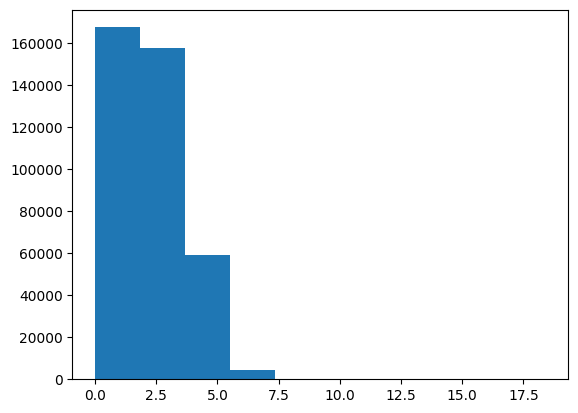

In [49]:
plt.hist(np.log1p(data_eau[data_eau['valeur_active']>0]['valeur_active']))

Il y a des valeurs nulles et quelques valeurs extremes à retirer

## nettoyage

Convertir la colonne valeur_date en type datetime qui sera plus facile à manipuler avec pandas et retirer les valeurs nan ou négatives

In [50]:
# retirer valeur négatives
data_eau[data_eau['valeur_active']<0]=np.nan

# retirer les valeurs extrèmes
data_eau[data_eau['valeur_active']>np.expm1(7.5)]=np.nan

# retirer nan
data_eau = data_eau[data_eau["valeur_active"].notna()].copy()
data_eau.info()

<class 'pandas.core.frame.DataFrame'>
Index: 448597 entries, 0 to 470760
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   valeur_active  448597 non-null  float64       
 1   valeur_date    448597 non-null  object        
 2   libelle        448597 non-null  object        
 3   date           448597 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 17.1+ MB


In [51]:
data_eau.describe()

,valeur_active,date
count,448597.000000,448597
mean,22.282182,2023-06-07 01:12:53.186624
min,0.000000,2019-01-01 00:00:00
25%,0.798434,2022-09-25 00:00:00
50%,5.100000,2023-07-28 00:00:00
75%,20.000000,2024-04-22 00:00:00
max,1561.700000,2024-12-31 00:00:00
std,54.137274,NaN


## Analyse du nombre de compteur actif

In [52]:
data_metrics = (
    data_eau
      .groupby(data_eau['date'].dt.to_period('D'))
      .agg(
          nb_unique_libelle=("libelle", "nunique"),
          nb_valeur_active=("valeur_active", "count"),
          min_valeur_active=("valeur_active", "min"),
          max_valeur_active=("valeur_active", "max"),
          moy_valeur_active=("valeur_active", "mean"),
      )
)

In [53]:
data_metrics.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 2192 entries, 2019-01-01 to 2024-12-31
Freq: D
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   nb_unique_libelle  2192 non-null   int64  
 1   nb_valeur_active   2192 non-null   int64  
 2   min_valeur_active  2192 non-null   float64
 3   max_valeur_active  2192 non-null   float64
 4   moy_valeur_active  2192 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 102.8 KB


<Axes: xlabel='date'>

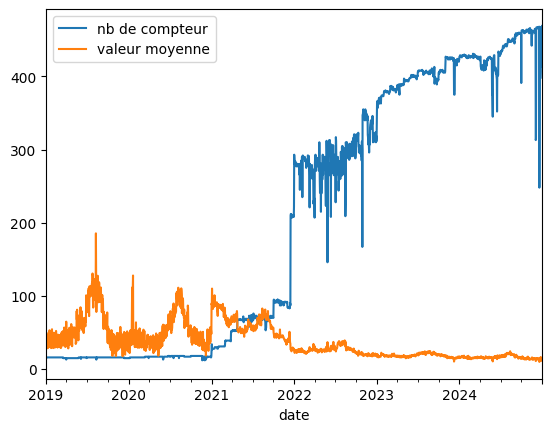

In [54]:
data_metrics['nb_unique_libelle'].plot(label="nb de compteur", legend=True)
data_metrics['moy_valeur_active'].plot(label="valeur moyenne", legend=True)


Il existe quatre périodes :
- 2019-2020 : 20 compteurs
- 2021 : ajout progressif d'une centaine de compteurs
- 2022 : ajout de 200 compteurs avec beaucoup de valeurs manquantes
- 2023-2024 : stabilisation des valeurs et ajout progressif jusqu'à un total de 450 compteurs

# Exploration des compteurs

## Sélection des dates

On explore sur la période 2022-24 qui est celle avec le plus de compteurs

In [55]:
start_date = "2022-01-01"
data=data_eau[(data_eau["date"]>=start_date)].copy()

In [56]:
print(f"nombre de compteurs : {len(data['libelle'].unique())}")

nombre de compteurs : 490


## Pré-visualisation des données

Afficher quelques courbes

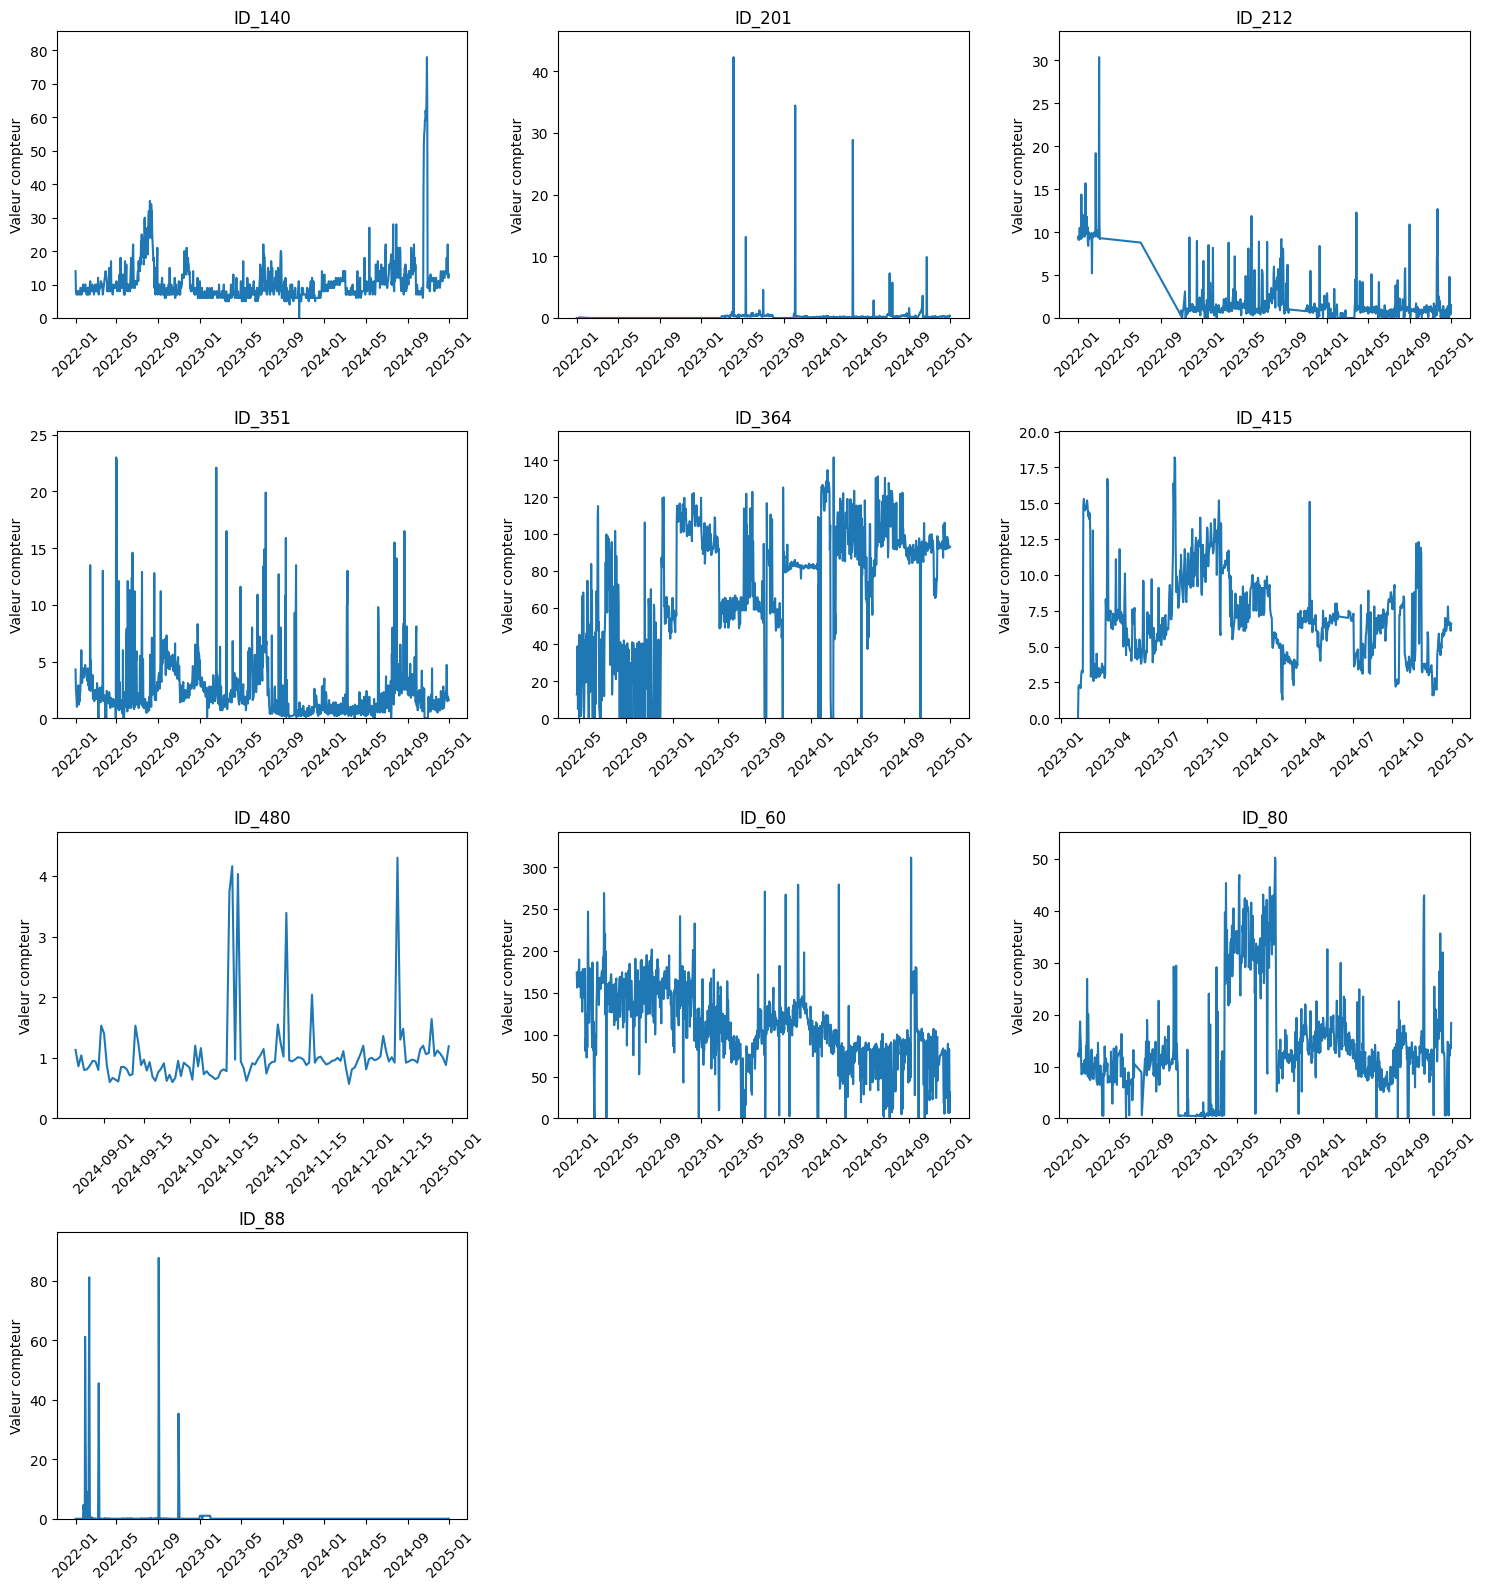

In [57]:
libelles_aleatoires = np.random.choice(
    data["libelle"].unique(),
    size=10,
    replace=False
)
impression(data[data['libelle'].isin(libelles_aleatoires)])

L'observation des compteurs montrent :
- valeurs manquantes
- valeurs nulles
- valeurs pics (valeur significativement élecvée pendant une période très courte)

L'observation montre aussi des fluctuations quotidiennes importantes et ce qu'il semble être une saisonnalité annuelle pour certains compteurs.

## Nettoyage

In [58]:
# retirer valeur nulles
data[data['valeur_active']==0]=np.nan
data = data[data["valeur_active"].notna()].copy()

In [59]:

# retirer les compteurs avec moins de 80% de données
nbre_valeur_par_compteur=(data
    .groupby('libelle')['valeur_active']
    .count())

In [60]:
nbre_valeur_par_compteur.describe()

count     485.000000
mean      733.523711
std       346.089127
min         1.000000
25%       487.000000
50%       856.000000
75%      1038.000000
max      1125.000000
Name: valeur_active, dtype: float64

Text(0.5, 1.0, 'nombre de compteur par nombre de valeur')

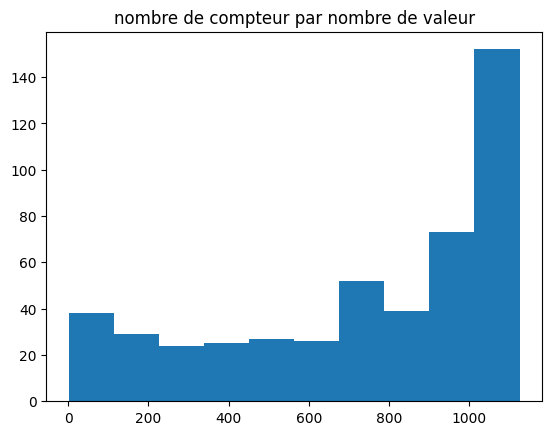

In [61]:
plt.hist(nbre_valeur_par_compteur)
plt.title('nombre de compteur par nombre de valeur')

In [62]:
seuil = 0.8 * nbre_valeur_par_compteur.max()
libelles_volumineux = nbre_valeur_par_compteur[nbre_valeur_par_compteur > seuil].index
data=data[data['libelle'].isin(libelles_volumineux)].copy()

In [63]:
print(f"nombre de compteurs : {len(data['libelle'].unique())}")

nombre de compteurs : 225


## Clusterisation

le client a préciser qu'il existait deux catégories de compteurs selon le débit. Nous allons séparer les compteurs en cluster et conserver le cluster principal.

In [64]:
moyenne_par_compteur=data.groupby('libelle')['valeur_active'].mean().reset_index()
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(moyenne_par_compteur[['valeur_active']])
labels = kmeans.labels_
centers = kmeans.cluster_centers_
moyenne_par_compteur["cluster"] = labels

In [65]:
moyenne_par_compteur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   libelle        225 non-null    object 
 1   valeur_active  225 non-null    float64
 2   cluster        225 non-null    int32  
dtypes: float64(1), int32(1), object(1)
memory usage: 4.5+ KB


In [66]:
moyenne_par_compteur.groupby('cluster')['valeur_active'].agg(['count','max', 'mean'])

,count,max,mean
cluster,,,
0,200,71.733457,13.872179
1,25,392.242173,132.887798


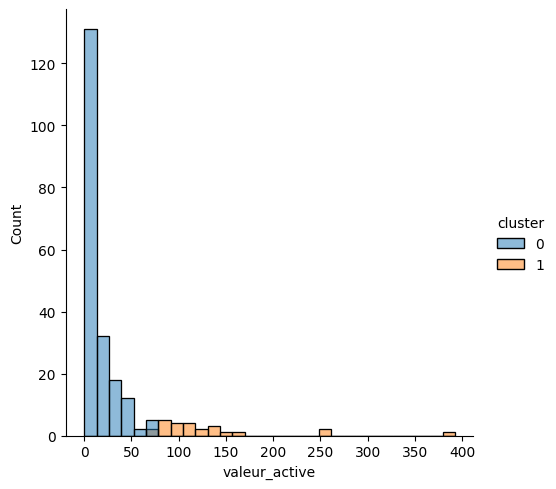

In [67]:
sns.displot(data=moyenne_par_compteur, x="valeur_active", hue="cluster")

In [68]:
cluster_principal = moyenne_par_compteur['cluster'].value_counts().idxmax()
libelles_principaux = moyenne_par_compteur[moyenne_par_compteur['cluster'] == cluster_principal]['libelle']
data=data[data['libelle'].isin(libelles_principaux)].copy()

In [69]:
print(f"nombre de compteurs : {len(data['libelle'].unique())}")

nombre de compteurs : 200


## Analyse de la saisonnalité annuelle

Nous utilisons le Coeeficient de Variation (CV) mensuel pour mesurer la saisonnalité annuelle

In [70]:
data_metrics = (
    data
      .groupby([data_eau['date'].dt.month, "libelle"])
      .agg(
          nb_valeur_active=("valeur_active", "count"),
          min_valeur_active=("valeur_active", "min"),
          max_valeur_active=("valeur_active", "max"),
          moy_valeur_active=("valeur_active", "mean"),
      ).rename_axis(index=["mois", "libelle"])
)
data_metrics=data_metrics.groupby("libelle").agg(
    min_mensuel=("moy_valeur_active", 'min'),
    max_mensuel=("moy_valeur_active", 'max'),
    moy_mensuel=("moy_valeur_active", 'mean'),
    std_mensuel=("moy_valeur_active", 'std'),
)

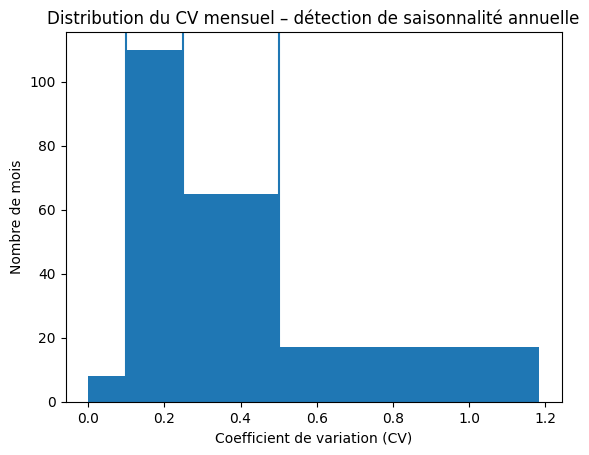

In [71]:

cv = data_metrics["std_mensuel"] / data_metrics["moy_mensuel"]

# Définition des bins selon les seuils de saisonnalité
bins = [0, 0.1, 0.25, 0.5, np.max(cv) + 1e-6]

plt.hist(cv, bins=bins)

# Lignes verticales pour les seuils clés
plt.axvline(0.1)
plt.axvline(0.25)
plt.axvline(0.5)

plt.xlabel("Coefficient de variation (CV)")
plt.ylabel("Nombre de mois")
plt.title("Distribution du CV mensuel – détection de saisonnalité annuelle")

plt.show()

|CV|	Interprétation|
|-|-|
|< 0.1|	Pas de saisonnalité|
|0.1 – 0.25|	Faible / incertaine|
|≥ 0.25	|Saisonnalité significative|
|≥ 0.5	|Saison forte|

40% des compteurs ont une saisonnalité annuelle significative à forte

## Analyse du bruit

Nous utilisons le Signal-to-Noise Ratio (SNR) quotidien pour analyser le bruit résiduel. Au préalable, un resample quotidien est nécessaire

In [75]:
def resample_and_interpolate(group):
    # Trier par date
    group = group.sort_values('date').set_index('date')
    
    # Resample quotidien uniquement avec moyenne pour doublon
    group_num = group[['valeur_active']].resample('D').mean()
    
    # Interpolation time
    group_num['valeur_active'] = group_num['valeur_active'].interpolate(method='time')
    
    # Remettre libelle
    group_num['libelle'] = group['libelle'].iloc[0]
    
    return group_num

# Appliquer par libelle
#group_keys=False pour que le libelle ne soit pas ajouté comme index supplémentaire
#reset index pour mettre les dates resamplée en colonnes
data_resampled = data.groupby('libelle', group_keys=False).apply(resample_and_interpolate).reset_index()


/tmp/ipykernel_12880/1685603811.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_resampled = data.groupby('libelle', group_keys=False).apply(resample_and_interpolate).reset_index()


In [ ]:
# ajout des composantes de la STL
def add_stl_components(group, period=365):
    """
    Ajoute les colonnes trend, seasonal et resid pour chaque libelle
    """
    series = group['valeur_active']
    
    # Décomposition STL
    stl = STL(series, period=period, robust=True)
    res = stl.fit()
    
    # Ajouter les colonnes au groupe
    group = group.copy()
    group['trend'] = res.trend
    group['seasonal'] = res.seasonal
    group['resid'] = res.resid
    
    return group

csv_file = f"{file_path}/data_with_stl.csv"

if os.path.exists(csv_file):
    # Charger le CSV existant
    data_with_stl = pd.read_csv(csv_file)
    print(f"CSV chargé depuis {csv_file}")
else:
    # Calculer STL par libelle
    data_with_stl = data_resampled.groupby('libelle', group_keys=False).apply(add_stl_components)
    
    # Sauvegarder en CSV
    data_with_stl.to_csv(csv_file, index=False)
    print(f"CSV généré et sauvegardé dans {csv_file}")

/tmp/ipykernel_12880/693263296.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_with_stl = data_resampled.groupby('libelle', group_keys=False).apply(add_stl_components)


In [79]:

def compute_snr_from_stl(df, libelle_col='libelle'):
    """
    Calcule le SNR par libelle à partir d'un DataFrame contenant
    les colonnes 'trend', 'seasonal', 'resid'.
    
    SNR = variance(signal) / variance(noise)
    signal = trend + seasonal
    noise = resid
    """
    snr_by_libelle = {}

    for libelle, group in df.groupby(libelle_col):
        signal_var = (group['trend'] + group['seasonal']).var()
        noise_var = group['resid'].var()
        snr = signal_var / noise_var if noise_var != 0 else float('inf')
        snr_by_libelle[libelle] = snr

    return pd.Series(snr_by_libelle, name='SNR')

# Exemple d'utilisation
# df_with_stl = df_resampled après ajout STL
snr_series = compute_snr_from_stl(data_with_stl)




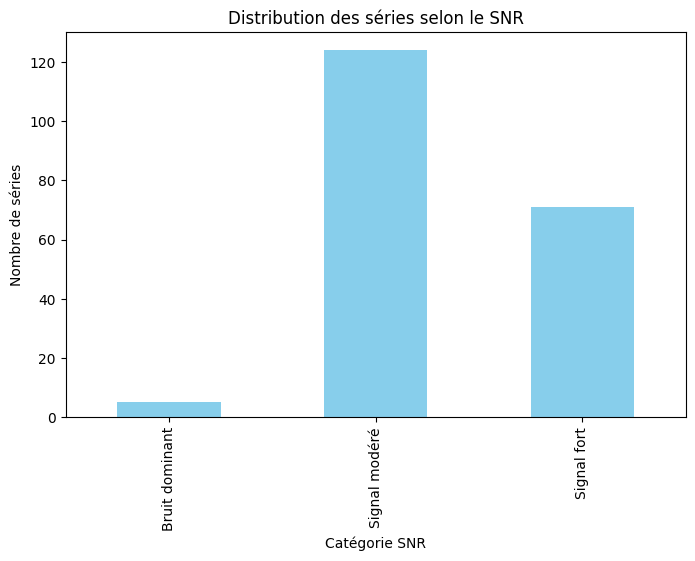

In [81]:
# Supposons snr_series est un pd.Series des SNR par libelle
# Définir les bins et labels
bins = [0, 1, 5, float('inf')]
labels = ['Bruit dominant', 'Signal modéré', 'Signal fort']

# Ajouter une colonne catégorielle
snr_df = snr_series.reset_index()
snr_df.columns = ['libelle', 'SNR']
snr_df['SNR_bin'] = pd.cut(snr_df['SNR'], bins=bins, labels=labels, right=False)

# Histogramme
plt.figure(figsize=(8,5))
snr_df['SNR_bin'].value_counts().reindex(labels).plot(kind='bar', color='skyblue')
plt.xlabel('Catégorie SNR')
plt.ylabel('Nombre de séries')
plt.title('Distribution des séries selon le SNR')
plt.show()

|SNR|	Interprétation|
|-|-|
|< 1|	Le **bruit domine** la série. Les modèles basés sur tendance/saisonnalité auront peu de précision.|
|1–5|	Le signal est **modéré** mais plus fort que le bruit, série assez régulière, prévisions relativement fiables.|
|> 5|	Le **signal domine** largement, la série est très prévisible, bruit faible.|

Le bruit est présent mais ne devrait pas empécher de faire des prévisions

Text(0.5, 1.0, 'ID_355')

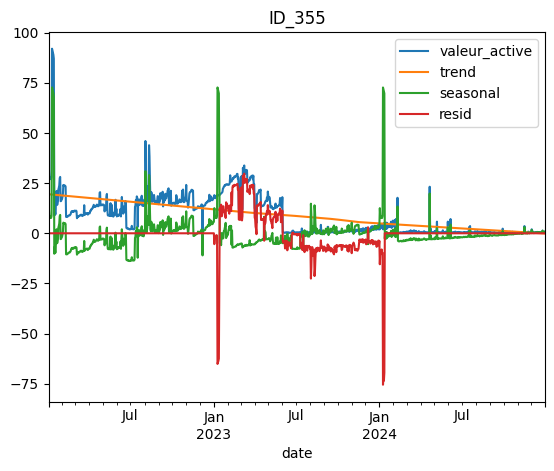

In [85]:
libelle='ID_355'
data_with_stl[data_with_stl['libelle']==libelle].set_index('date').plot()
plt.title(libelle)